# I)

In [52]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def mypgmread(filename):
    
    with open(filename, 'rb') as f:
        
        # Dosyanın ilk iki baytınının "P5" olup olmadığını kontrol et
        magic_number = f.readline().decode('ascii').strip()
        assert magic_number == 'P5', 'Invalid PGM'

        
        while True:
            #Dosyadan bir satır oku, ASCII karakterlere çevir, başındaki ve sonundaki boşlukları temizle
            line = f.readline().decode('ascii').strip()
            if not line.startswith('#'):# Yorum satırlarını atla
                break

        # Genişlik, yükseklik ve maksimum değeri oku
        
        width, height = map(int, line.split()) #line adındaki stringi boşluk karakterlerine göre ayırır bu ayrılmış liste üzerinde int fonksiyonunu her bir elemana uygula
        maxval = int(f.readline().decode('ascii').strip())

        image_data = []#Görüntü verisini depolamak için liste oluştur
        
        for _ in range(height):
            row = []
            for _ in range(width):
                pixel_value = ord(f.read(1))#Dosyadan bir bayt oku ve ASCII değere dönüştür
                row.append(pixel_value)
            image_data.append(row)

        return image_data, width, height, maxval

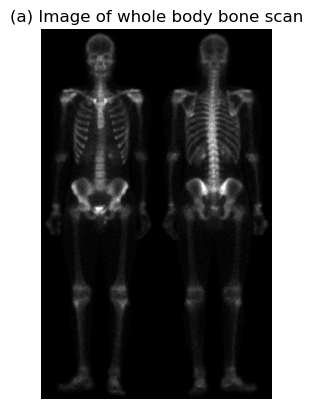

In [54]:
image_data, width, height, maxval = mypgmread('Fig0343(a)(skeleton_orig).pgm')

plt.title("(a) Image of whole body bone scan")
plt.imshow(image_data, cmap='gray')
plt.axis('off') 
plt.show()

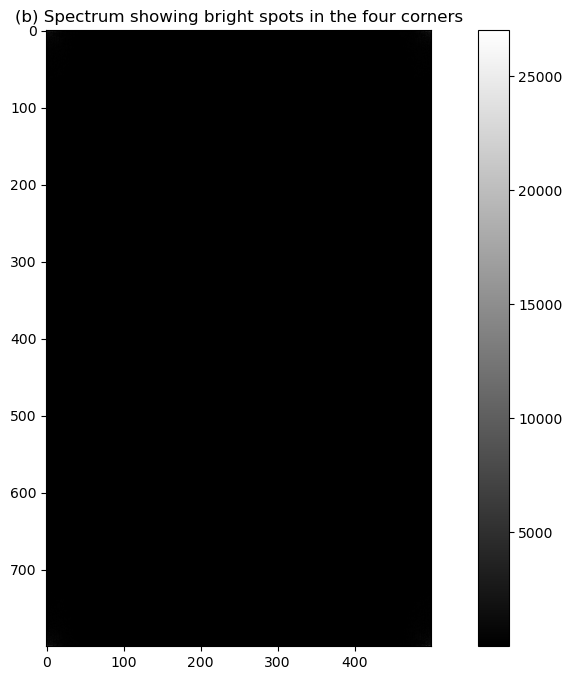

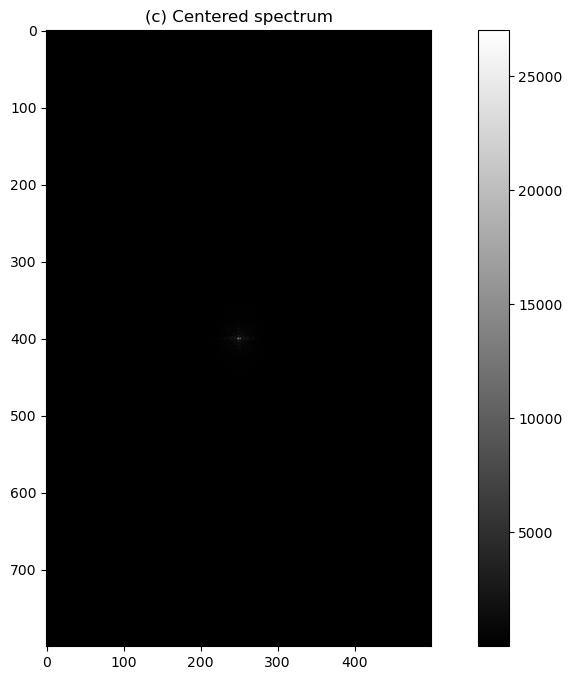

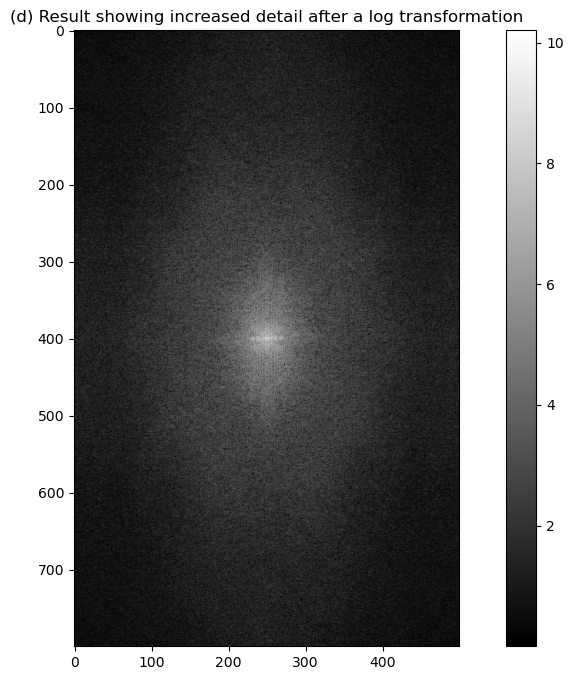

In [55]:
def my2Dfft(image_data):
    # Satırlara tek boyutlu Fourier dönüşümü uygula
    rows = np.fft.fft(image_data, axis=1)
    
    # Sütunlara tek boyutlu Fourier dönüşümü uygula
    columns = np.fft.fft(rows, axis=0)
    
    return columns

image_data, width, height, maxval = mypgmread('Fig0343(a)(skeleton_orig).pgm')
image_data=np.array(image_data)
image_data=image_data/maxval
# 2D FFT al
fft_image_data = my2Dfft(image_data)

# 2D Fourier dönüşüm sonuçlarını görselleştir
plt.figure(figsize=(12,8))
plt.imshow(np.abs(fft_image_data), cmap='gray')# 2D Fourier dönüşüm sonucu 
plt.title("(b) Spectrum showing bright spots in the four corners")
plt.colorbar()
plt.show()


# DC noktasını kaydırmak için (M/2, N/2) noktasına -1^(x+y) ile çarpılan görüntüyü kullan
centered = image_data * (-1) ** (np.arange(height)[:, None] + np.arange(width)[None, :])
fft__centered = my2Dfft(centered)

# Görüntüleri görselleştir
plt.figure(figsize=(12,8))
plt.imshow(np.abs(fft__centered), cmap='gray')
plt.title("(c) Centered spectrum")
plt.colorbar()

plt.figure(figsize=(12,8))
plt.imshow(np.log(1 + np.abs(fft__centered)), cmap='gray')
plt.title("(d) Result showing increased detail after a log transformation")
plt.colorbar()

plt.show()

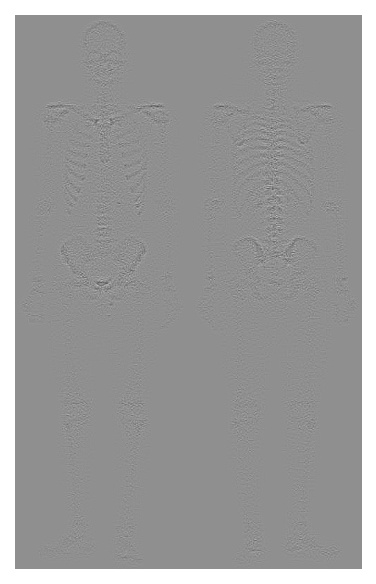

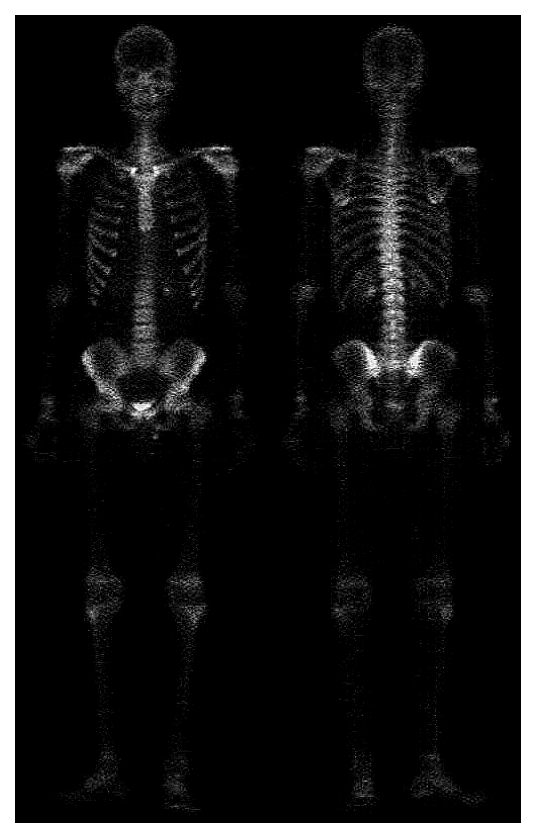

In [56]:
P, Q = fft__centered.shape
H = np.zeros((height, width))
for u in range(P):
    for v in range(Q):
        H[u, v] = -4 * np.pi**2 * ((u - P/2)**2 + (v - Q/2)**2)

# Laplacian uygula
Lap = H * fft__centered
Lap = np.fft.ifftshift(Lap)
Lap = np.real(np.fft.ifft2(Lap))

# range [-1, 1]
OldRange = np.max(Lap) - np.min(Lap)
NewRange = 1 - -1
LapScaled = (((Lap - np.min(Lap)) * NewRange) / OldRange) + -1

plt.figure(dpi=150)
plt.imshow(LapScaled, cmap='gray')
plt.axis('off')
plt.show()

# uzamsal denklem
c = -1
g = image_data + c * LapScaled
g = np.clip(g, 0, 1)

plt.figure(figsize=(5, 7), dpi=150)
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()


In [1]:
def my_filter(data,size,width,height):
    lp_matrix1=np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    lp_matrix2=np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


    data = np.array(data,dtype=np.uint8)
    
    padding = size // 2  # Ekstra sütun/satır sayısı, filtre boyutunun yarısı kadar

    #görüntü kenarındaki pikselleri korumak için 
    w = np.zeros((height + 2*padding, width + 2*padding))# w-> görüntü verisini çerçeveler filtre size ına göre 
    
    for i in range(0,height):    
        for j in range(0,width):
            w[i + padding][j + padding] = data[i][j]
            

    filtered1 = np.zeros((height,width))
    filtered2 = np.zeros((height,width))


    for i in range(0,height):
        for j in range(0,width):
            
            filtered1[i][j] =filtered1[i][j]+ int(np.sum(w[i:size+i,j:size+j]*lp_matrix1))#filtrelenmiş görüntü verisini tutar
            
            filtered2[i][j]= filtered1[i][j]+ int(np.sum(w[i:size+i,j:size+j]*lp_matrix2))#filtrelenmiş görüntü verisini tutar
   
    gradient_magnitude = np.sqrt(filtered1**2 + filtered2**2)

        
    return gradient_magnitude
    

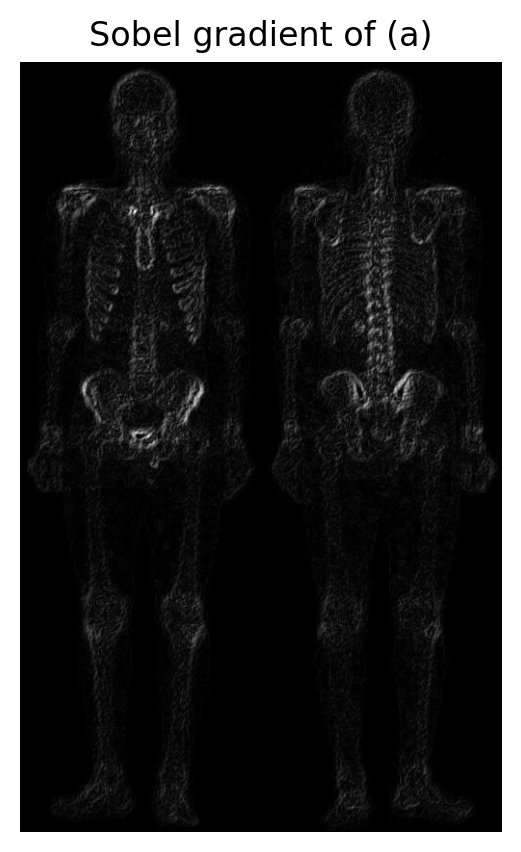

In [58]:
image_data, width, height, maxval = mypgmread('Fig0343(a)(skeleton_orig).pgm')
sobel=my_filter(image_data,3,width, height)

plt.figure(figsize=(18, 5), dpi=200)
plt.title("Sobel gradient of (a)")
plt.imshow(sobel, cmap='gray')
plt.axis('off') 
plt.show()

In [59]:
def averageMaskFilter(data,size,width,height):
   
    data = np.array(data,dtype=np.uint8)
    
    padding = size // 2  # Ekstra sütun/satır sayısı, filtre boyutunun yarısı kadar

    #görüntü kenarındaki pikselleri korumak için 
    w = np.zeros((height + 2*padding, width + 2*padding))# w-> görüntü verisini çerçeveler filtre size ına göre 
    
    for i in range(0,height):    
        for j in range(0,width):
            w[i + padding][j + padding] = data[i][j]
            

    filtered = np.zeros((height,width))
    for i in range(0,height):
        for j in range(0,width):
            filtered[i][j] = int(np.mean(w[i:size+i,j:size+j]))#filtrelenmiş görüntü verisini tutar
            
    return filtered

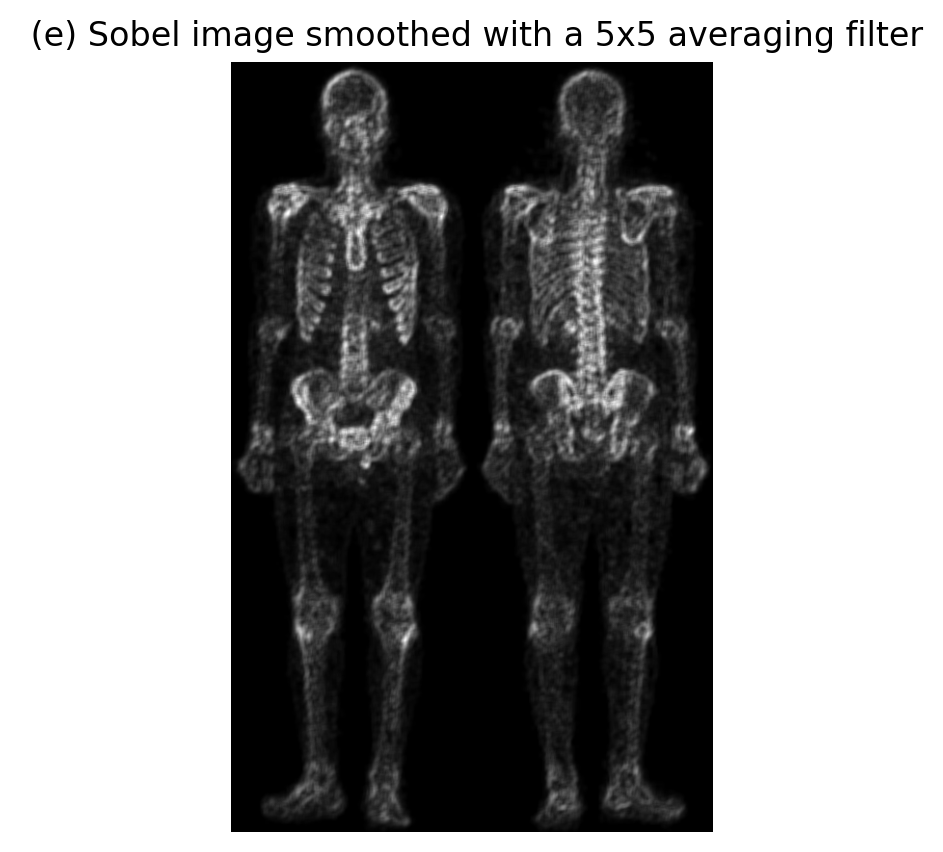

In [60]:
fig=averageMaskFilter(sobel,5,width,height)
plt.figure(figsize=(12, 5), dpi=200)
plt.title(" (e) Sobel image smoothed with a 5x5 averaging filter")
plt.imshow(fig, cmap='gray')
plt.axis('off') 
plt.show()


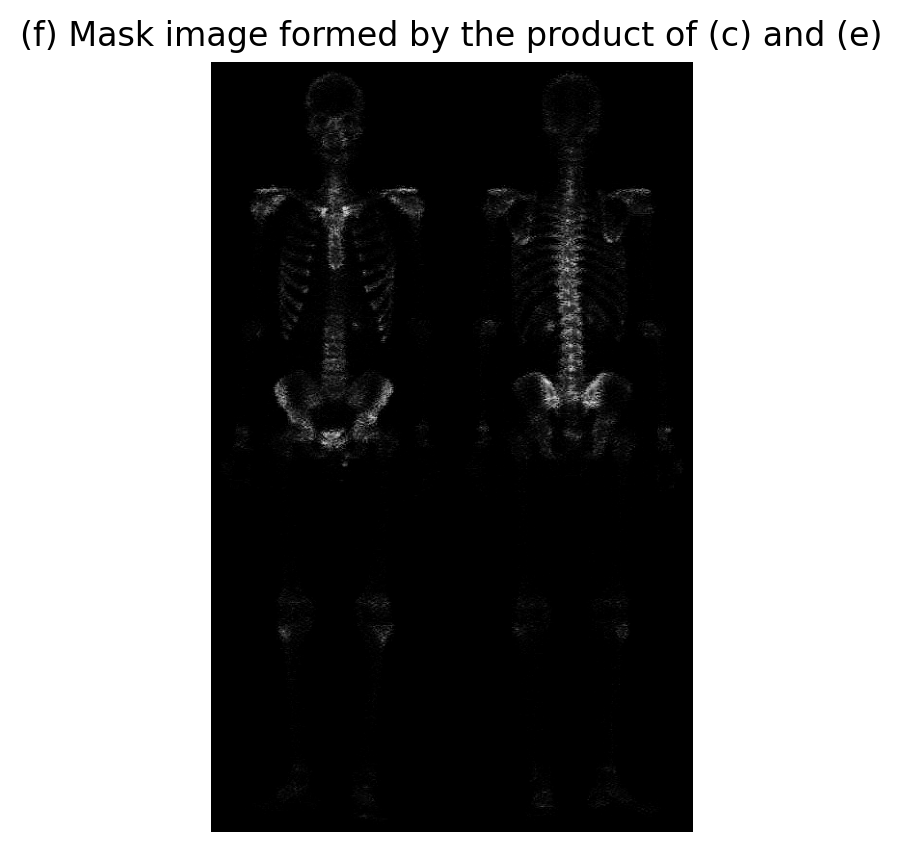

In [61]:
product=fig*g
plt.figure(figsize=(12, 5), dpi=200)
plt.title("(f) Mask image formed by the product of (c) and (e)")
plt.imshow(product, cmap='gray')
plt.axis('off') 
plt.show()

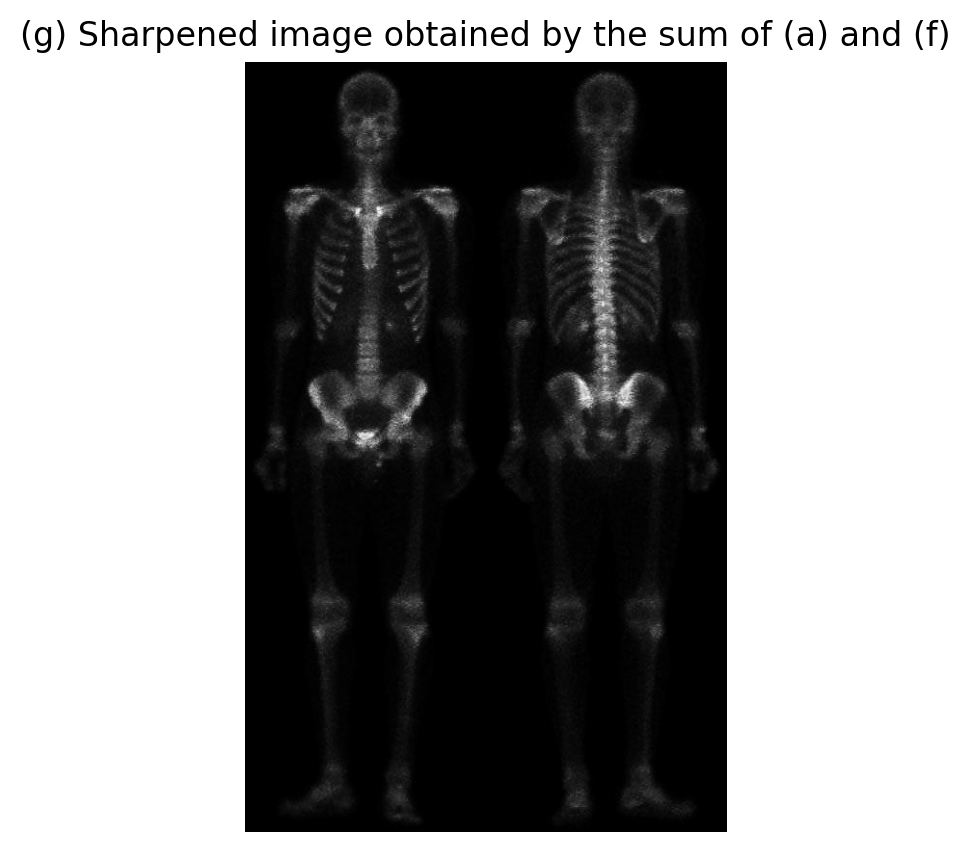

In [62]:
image_data, width, height, maxval = mypgmread('Fig0343(a)(skeleton_orig).pgm')
add=product+image_data
plt.figure(figsize=(12, 5), dpi=200)
plt.title("(g) Sharpened image obtained by the sum of (a) and (f)")
plt.imshow(add, cmap='gray')
plt.axis('off') 
plt.show()

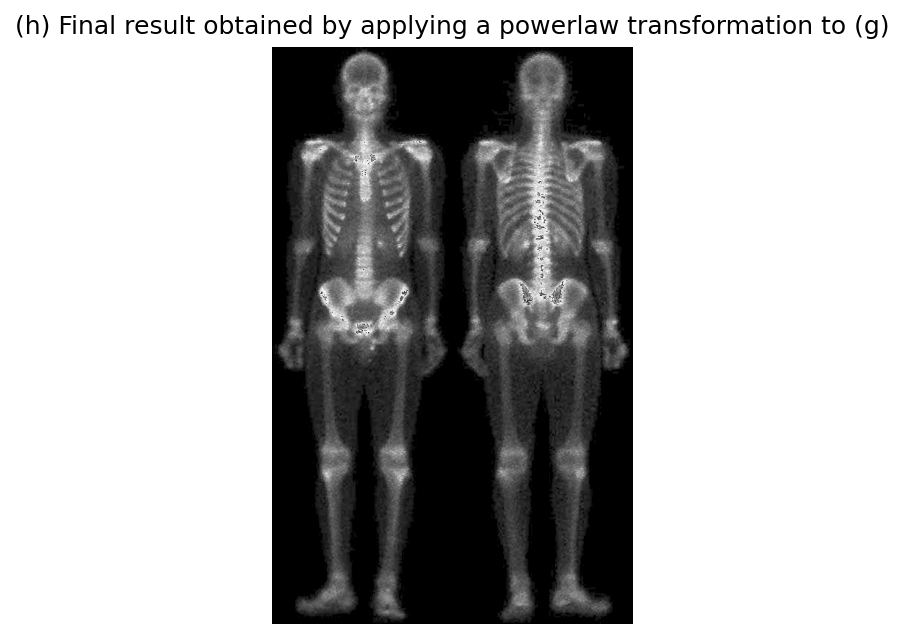

In [63]:
def my_gammatransform(data,gamma):
    image_array = np.array(data, dtype=np.uint8)# numpy dizisine çevir
    
    transform=pow(image_array,gamma)
    return transform

gamm=my_gammatransform(add,0.5)
plt.figure(figsize=(12, 5), dpi=150)
plt.title("(h) Final result obtained by applying a powerlaw transformation to (g)")
plt.imshow(gamm, cmap='gray')
plt.axis('off') 
plt.show()


# II)

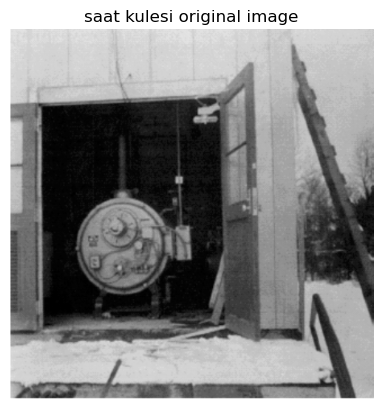

In [162]:
image_data, width, height, maxval = mypgmread('Figure Saat Kulesi 1.pgm')

plt.title("saat kulesi original image")
plt.imshow(image_data, cmap='gray')
plt.axis('off') 
plt.show()

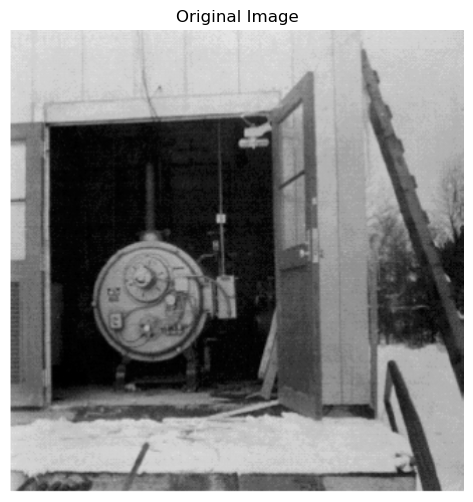

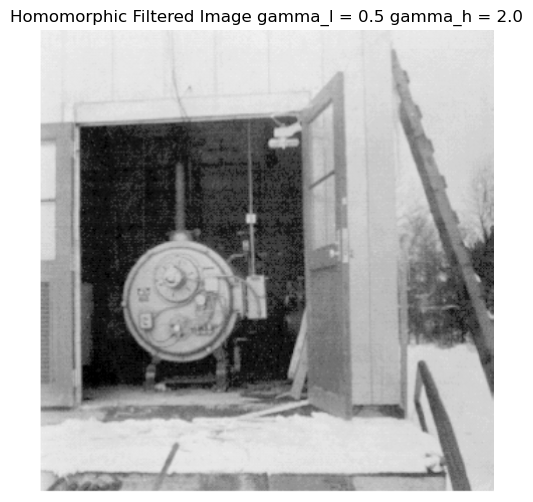

In [164]:
def homomorphic_filter(image, gamma_l, gamma_h, c, D0):

    log_image = np.log1p(np.array(image, dtype="float"))
    image=np.array(image)
    image=image/255
    # Fourier transform
    fft_image = my2Dfft(log_image)

    # Create a high-pass filter
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones((rows, cols))
    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            mask[i, j] = (gamma_h - gamma_l) * (1 - np.exp(-c * (distance*2) / (D0**2))) + gamma_l

    fft_image_filtered = fft_image * mask

    # Inverse Fft
    homomorphic_result = np.abs(np.fft.ifft2(fft_image_filtered))

    homomorphic_result = np.expm1(homomorphic_result)

    return homomorphic_result

# Parametreler
gamma_l = 0.5
gamma_h = 2.0
c = 1
D0 = np.sqrt((height/2 - 2 )**2 + (width/2- 2)**2)
image_data, width, height, maxval = mypgmread('Figure Saat Kulesi 1.pgm')
# homomorfic filtre
homomorphic_result = homomorphic_filter(image_data, gamma_l, gamma_h, c, D0)


plt.figure(figsize=(12, 6))
plt.title("Original Image")
plt.imshow(image_data, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Homomorphic Filtered Image gamma_l = 0.5 gamma_h = 2.0")
plt.imshow(homomorphic_result, cmap='gray')
plt.axis('off')

plt.show()

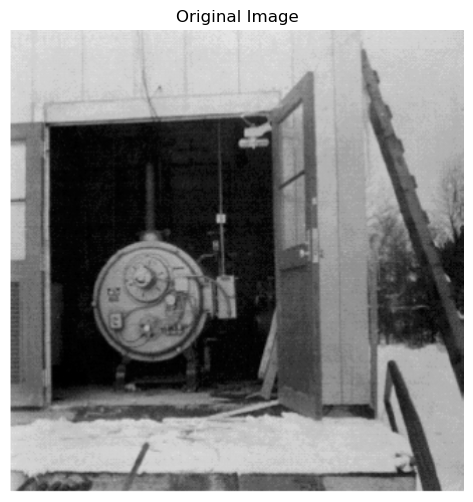

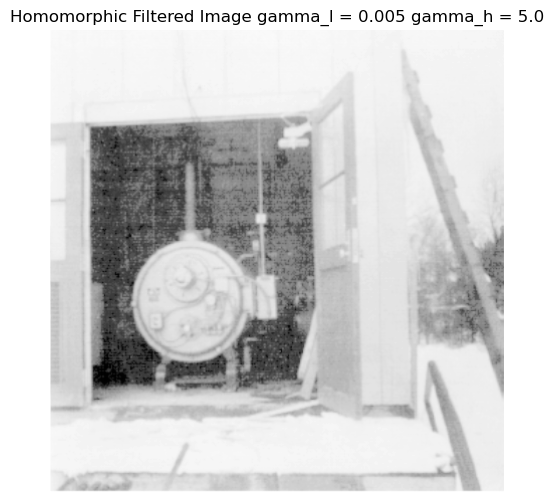

In [167]:

# Parameters for the homomorphic filter
gamma_l = 0.005
gamma_h = 5.0
c = 1
D0 = np.sqrt((height/2 - 2 )**2 + (width/2- 2)**2)
# Apply homomorphic filter to the image
image_data, width, height, maxval = mypgmread('Figure Saat Kulesi 1.pgm')

homomorphic_result = homomorphic_filter(image_data, gamma_l, gamma_h, c, D0)

# Display the original and filtered images
plt.figure(figsize=(12, 6))
plt.title("Original Image")
plt.imshow(image_data, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Homomorphic Filtered Image gamma_l = 0.005 gamma_h = 5.0")
plt.imshow(homomorphic_result, cmap='gray')
plt.axis('off')

plt.show()

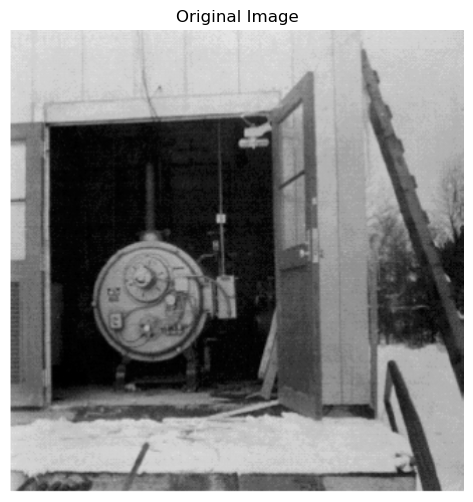

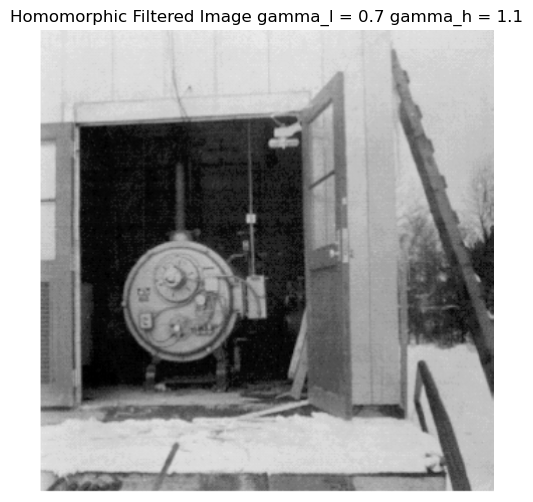

In [168]:
# Parameters for the homomorphic filter
gamma_l = 0.7
gamma_h = 1.1
c = 30
D0 = np.sqrt((height/2 - 2 )**2 + (width/2- 2)**2)
# Apply homomorphic filter to the image
image_data, width, height, maxval = mypgmread('Figure Saat Kulesi 1.pgm')

homomorphic_result = homomorphic_filter(image_data, gamma_l, gamma_h, c, D0)

# Display the original and filtered images
plt.figure(figsize=(12, 6))
plt.title("Original Image")
plt.imshow(image_data, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Homomorphic Filtered Image gamma_l = 0.7 gamma_h = 1.1")
plt.imshow(homomorphic_result, cmap='gray')
plt.axis('off')

plt.show()